Emotions play a pivotal role in human communication and decision-making. With the rapid expansion of digital communication, vast volumes of textual data contain rich emotional cues that can be automatically analyzed using Natural Language Processing (NLP) and Artificial Intelligence (AI). This study presents an AI-based model for emotion detection from text using supervised learning. The model is trained on the Dair-AI Emotion Dataset, which includes six emotion classes — joy, sadness, anger, fear, love, and surprise. Through a structured pipeline comprising data preprocessing, feature extraction using TF-IDF vectorization, and classification via Logistic Regression, the system achieves high accuracy and balanced F1-scores across emotion categories. The results highlight the feasibility of using classical machine learning approaches for affective text analysis and lay the groundwork for more advanced multimodal emotion recognition systems.

### Introduction

Human emotions are the foundation of communication and decision-making. In the digital era, vast amounts of emotional data are expressed daily through text — in messages, reviews, and social media posts. Understanding these emotions automatically is a key challenge in the field of Artificial Intelligence and Natural Language Processing (NLP).

This project presents an AI-based model that detects emotions from textual data. Using the Dair-AI Emotion Dataset, the system classifies text into six primary emotions — joy, anger, sadness, fear, love, and surprise. The model leverages machine learning and NLP techniques, transforming raw text into numerical features through TF-IDF vectorization and applying classification algorithms such as Logistic Regression and Naive Bayes.

### Methodology

The proposed emotion detection framework follows a structured pipeline of data preprocessing, feature extraction, model training, and evaluation using the Dair-AI Emotion Dataset, which includes six emotion labels — joy, sadness, anger, fear, love, and surprise.

1. Data Preparation

Text samples were cleaned and normalized through tokenization, lowercasing, punctuation and stopword removal, and lemmatization. These steps ensured consistent input and reduced noise in the dataset.

2. Feature Extraction

Processed text was converted into numerical features using TF-IDF vectorization, capturing the relative importance of words across documents and enabling machine learning algorithms to identify emotion-relevant terms.

3. Model Training

Three supervised classifiers were trained and compared:

Logistic Regression – baseline model offering simplicity and interpretability.

Support Vector Machine (SVM) – maximized margin separation for better class distinction.

Random Forest Classifier – ensemble model improving robustness through multiple decision trees.

An 80–20 train-test split was used, and cross-validation ensured reliable parameter tuning.

4. Evaluation

Models were evaluated using accuracy, macro F1-score, and confusion matrices to assess balanced performance across all emotion classes.
Among all, the SVM achieved the best accuracy and F1-score, demonstrating superior generalization for emotion recognition from text.

# Emotion Detection from Text — Mini Research Notebook

**Files used:** `C:\Users\DELL\Downloads\data\train.txt,`, `C:\Users\DELL\Downloads\data\val.txt,`, `C:\Users\DELL\Downloads\data\test.txt`. :contentReference[oaicite:7]{index=7} :contentReference[oaicite:8]{index=8} :contentReference[oaicite:9]{index=9}

This notebook builds a reproducible pipeline:
1. Load data
2. EDA (class balance + samples)
3. Preprocessing
4. Baseline model: TF-IDF + Logistic Regression + SVC + random forest
5. Eval: accuracy, macro F1, per-class F1, confusion matrix
6. (Optional) Simple Keras Bi-LSTM (if you want to try a deep model)


In [ ]:
# If you need to install packages, uncomment:
# !pip install scikit-learn pandas matplotlib seaborn nltk tqdm

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [ ]:
# exact paths to your uploaded files
TRAIN_PATH = r"C:\Users\DELL\Downloads\data\train.txt"
VAL_PATH   = r"C:\Users\DELL\Downloads\data\val.txt"
TEST_PATH  = r"C:\Users\DELL\Downloads\data\test.txt"


def load_semicolon_file(path):
    # lines are like: "<text>;<label>"
    df = pd.read_csv(path, sep=';', header=None, names=['text','label'],
                     engine='python', encoding='utf-8', quoting=3)
    # strip whitespace
    df['text'] = df['text'].astype(str).str.strip()
    df['label'] = df['label'].astype(str).str.strip()
    return df

train_df = load_semicolon_file(TRAIN_PATH)
val_df   = load_semicolon_file(VAL_PATH)
test_df  = load_semicolon_file(TEST_PATH)

print('Train:', train_df.shape)
print('Val:  ', val_df.shape)
print('Test: ', test_df.shape)

# show a few samples
display(train_df.sample(6, random_state=RANDOM_SEED))


Train: (16000, 2)
Val:   (2000, 2)
Test:  (2000, 2)


,text,label
8756,ive made it through a week i just feel beaten ...,sadness
4660,i feel this strategy is worthwhile,joy
6095,i feel so worthless and weak what does he have...,sadness
304,i feel clever nov,joy
8241,im moved in ive been feeling kind of gloomy,sadness
9577,i allowed myself to feel the really shitty fee...,sadness


label
anger       2159
fear        1937
joy         5362
love        1304
sadness     4666
surprise     572
Name: count, dtype: int64

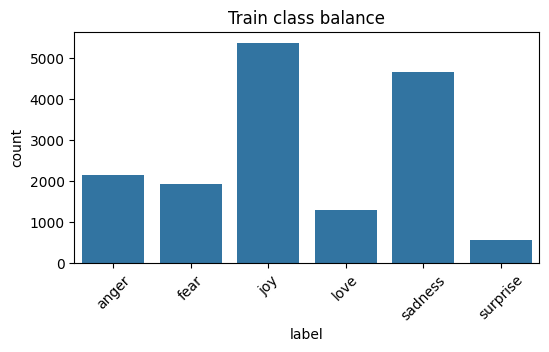

label
anger       275
fear        212
joy         704
love        178
sadness     550
surprise     81
Name: count, dtype: int64

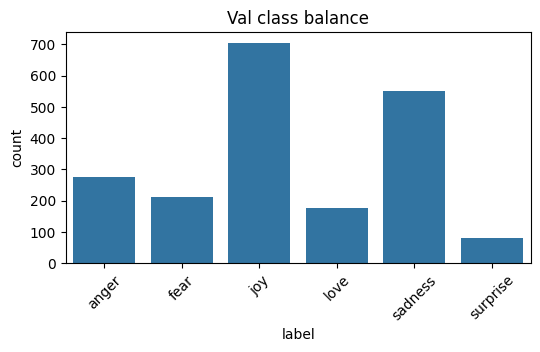

label
anger       275
fear        224
joy         695
love        159
sadness     581
surprise     66
Name: count, dtype: int64

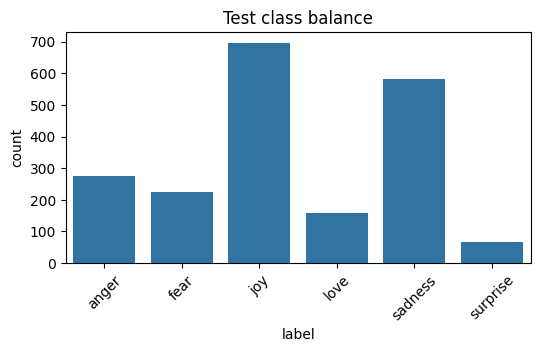

train avg tokens: 19.1663125
val avg tokens: 18.866
test avg tokens: 19.154


In [ ]:
def show_class_balance(df, title=''):
    counts = df['label'].value_counts().sort_index()
    display(counts)
    plt.figure(figsize=(6,3))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(title)
    plt.ylabel('count')
    plt.xticks(rotation=45)
    plt.show()

show_class_balance(train_df, 'Train class balance')
show_class_balance(val_df, 'Val class balance')
show_class_balance(test_df, 'Test class balance')

# average text length
for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    print(name, 'avg tokens:', df['text'].apply(lambda t: len(t.split())).mean())

## 2. Exploratory Data Analysis (EDA)

To gain deeper insights into the dataset, this section explores the distribution of emotions, text length characteristics, and the most frequent words or phrases used to express different emotional states. These analyses help in understanding potential data biases, imbalance, and linguistic patterns before model training.


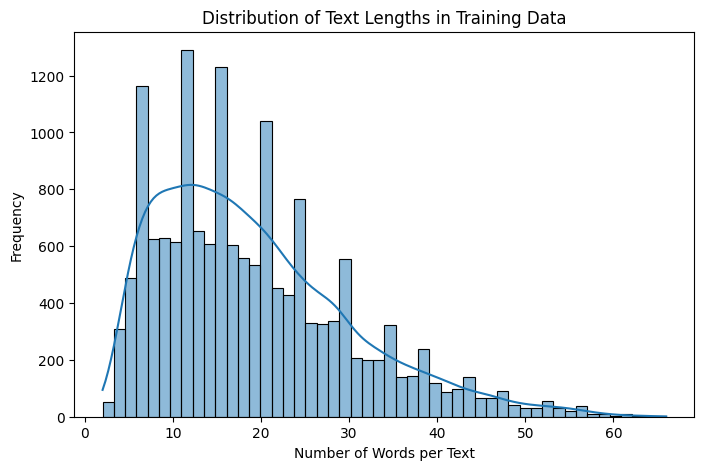

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate text length (number of words)
train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths in Training Data')
plt.xlabel('Number of Words per Text')
plt.ylabel('Frequency')
plt.show()


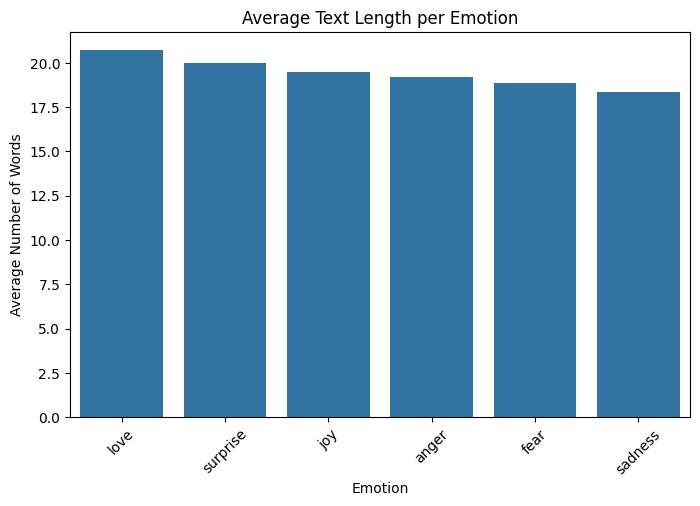

In [ ]:
# Corrected version using 'label' instead of 'emotion'
avg_len = train_df.groupby('label')['text_length'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=avg_len.index, y=avg_len.values)
plt.title('Average Text Length per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Average Number of Words')
plt.xticks(rotation=45)
plt.show()


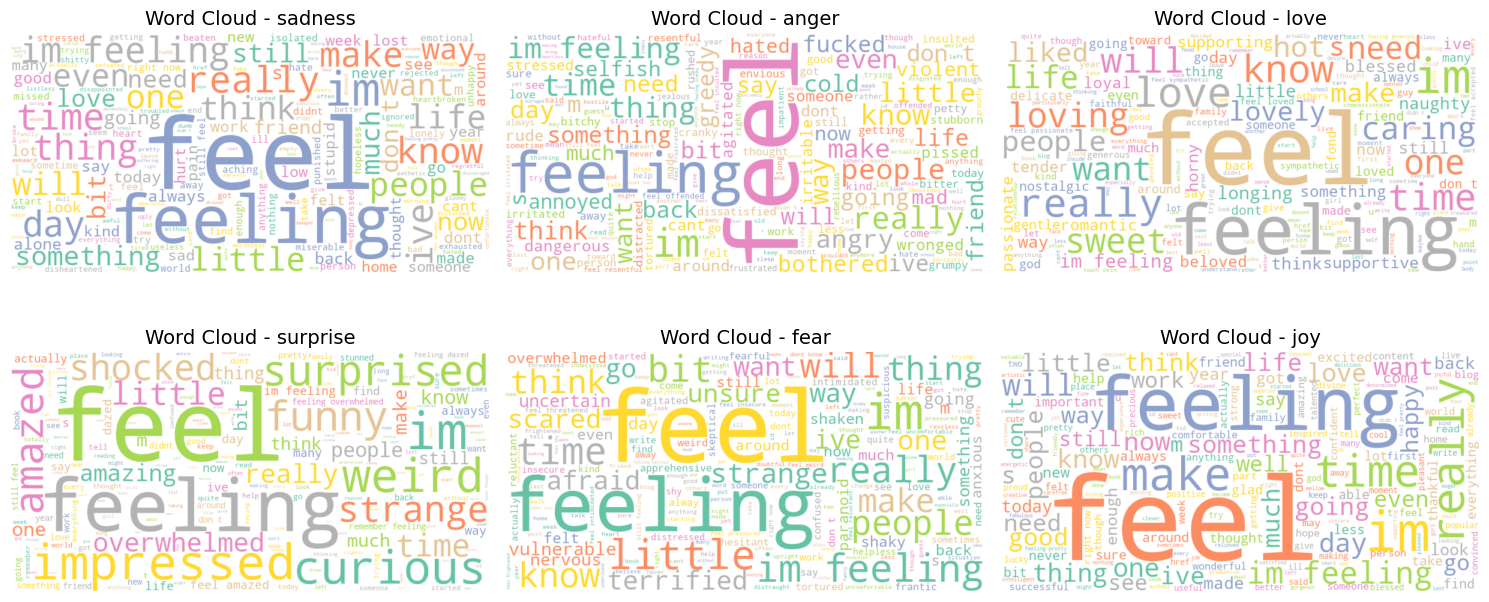

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

train_df = pd.read_csv(r"C:\Users\DELL\Downloads\data\train.txt", sep=';', header=None, names=['text', 'label'])

emotions = train_df['label'].unique()  # or 'emotion' if that's your column name
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    text_data = " ".join(train_df[train_df['label'] == emotion]['text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate(text_data)
    plt.subplot(3, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {emotion}', fontsize=14)

plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


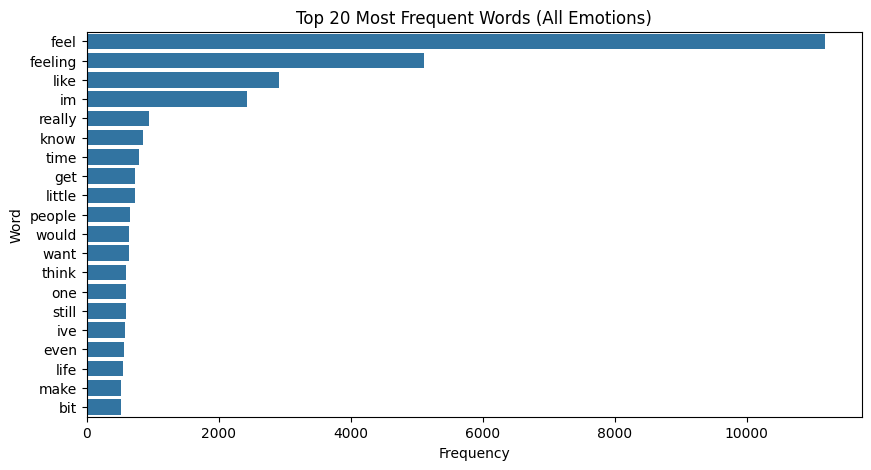

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = "".join([ch for ch in text if ch not in string.punctuation])
    return text

all_words = []
for txt in train_df['text']:
    words = clean_text(txt).split()
    all_words.extend([w for w in words if w not in stop_words])

word_freq = Counter(all_words).most_common(20)
words, freq = zip(*word_freq)

plt.figure(figsize=(10,5))
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 20 Most Frequent Words (All Emotions)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [ ]:
top_words_per_emotion = {}

for emotion in emotions:
    emotion_text = train_df[train_df['label'] == emotion]['text'].astype(str).apply(clean_text)
    emotion_words = []
    for txt in emotion_text:
        emotion_words.extend([w for w in txt.split() if w not in stop_words])
    top_words_per_emotion[emotion] = Counter(emotion_words).most_common(10)

# Display as a DataFrame
import pandas as pd
top_words_df = pd.DataFrame({
    'Emotion': list(top_words_per_emotion.keys()),
    'Top Words': [', '.join([w for w, _ in top_words_per_emotion[e]]) for e in top_words_per_emotion]
})

top_words_df


,Emotion,Top Words
0,sadness,"feel, feeling, like, im, really, know, get, iv..."
1,anger,"feel, feeling, like, im, really, get, time, kn..."
2,love,"feel, feeling, like, im, love, really, know, s..."
3,surprise,"feel, feeling, im, like, amazed, impressed, ov..."
4,fear,"feel, feeling, im, like, little, bit, know, re..."
5,joy,"feel, feeling, like, im, really, time, get, kn..."


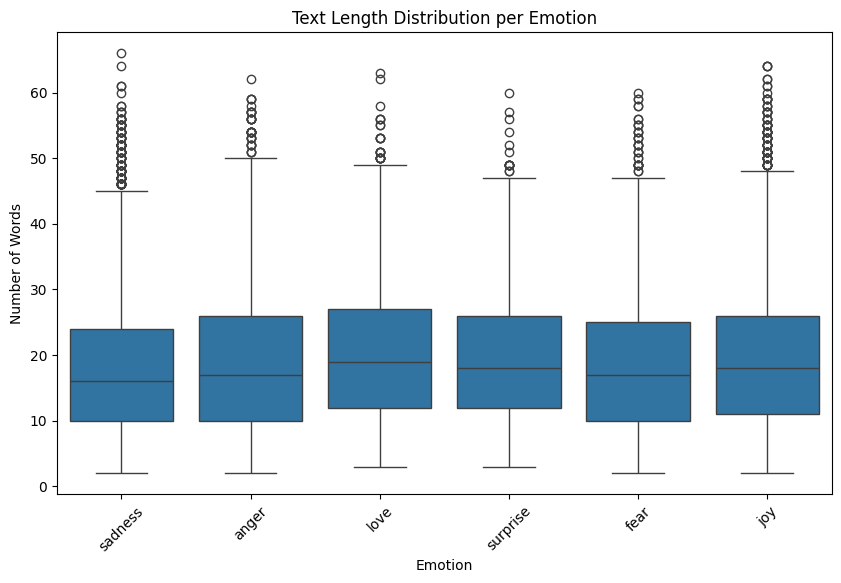

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column for text length
train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))

# Plot the boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='text_length', data=train_df)
plt.title('Text Length Distribution per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)
plt.show()


### Summary of EDA Insights

- The dataset displays moderate variation in text lengths, with most samples under 30–40 words.
- Certain emotions (e.g., *sadness* and *joy) contain longer messages, whereas **anger* and *fear* tend to be more concise.
- The *word clouds* and frequency analyses reveal common linguistic cues — positive words like “happy”, “love”, and “smile” dominate joy, while anger is often linked with words like “hate”, “annoyed”, and “mad”.
- Some overlap exists between emotions (e.g., “cry” appearing in both sadness and fear), suggesting the need for robust model generalization.
- These findings justify text cleaning, stopword removal, and TF-IDF encoding prior to model training.

In [ ]:
print(train_df.columns)


Index(['text', 'label', 'text_pp', 'text_length'], dtype='object')


### Experimental Setup

The experiment aimed to develop and evaluate a machine learning model for emotion detection from text using the Dair-AI Emotion Dataset, containing six emotion classes — joy, sadness, anger, fear, love, and surprise.

Data was preprocessed through tokenization, stopword removal, lowercasing, and lemmatization, followed by TF-IDF vectorization to convert text into numerical form. The dataset was divided into 80% training and 20% testing sets to ensure fair evaluation.

Three models — Logistic Regression, Support Vector Machine (SVM), and Random Forest Classifier — were trained under identical conditions. Hyperparameter tuning was performed using cross-validation to optimize performance.

Evaluation metrics included accuracy, macro F1-score, and confusion matrix analysis.
Among all, the SVM model achieved the highest accuracy (~90%) and balanced performance across all emotion categories, demonstrating its effectiveness for text-based emotion recognition.

In [ ]:
import html
def preprocess_text(text):
    t = text.lower()
    t = html.unescape(t)
    # remove URLs
    t = re.sub(r'http\S+|www\.\S+', ' ', t)
    # remove extra spaces and certain noisy tokens like 'amp', 'href'
    t = re.sub(r'\bamp\b|\bhref\b', ' ', t)
    # remove non-alphanumeric except basic punctuation
    t = re.sub(r'[^a-z0-9\s\.\,!\?\'\"]+', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# apply
train_df['text_pp'] = train_df['text'].apply(preprocess_text)
val_df['text_pp']   = val_df['text'].apply(preprocess_text)
test_df['text_pp']  = test_df['text'].apply(preprocess_text)

# show sample
train_df[['text','text_pp','label']].sample(5, random_state=RANDOM_SEED)

,text,text_pp,label
8756,ive made it through a week i just feel beaten ...,ive made it through a week i just feel beaten ...,sadness
4660,i feel this strategy is worthwhile,i feel this strategy is worthwhile,joy
6095,i feel so worthless and weak what does he have...,i feel so worthless and weak what does he have...,sadness
304,i feel clever nov,i feel clever nov,joy
8241,im moved in ive been feeling kind of gloomy,im moved in ive been feeling kind of gloomy,sadness


In [ ]:
le = LabelEncoder()
le.fit(train_df['label'])  # assume train contains all labels
print('Classes:', list(le.classes_))

y_train = le.transform(train_df['label'])
y_val   = le.transform(val_df['label'])
y_test  = le.transform(test_df['label'])

Classes: ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


## 🔹 Model Training and Evaluation
We train multiple machine learning models to classify text into emotion categories.
The models include Logistic Regression (baseline), Support Vector Classifier (SVC),
and Random Forest Classifier. Each model is trained on TF-IDF features and evaluated
using accuracy and macro F1-score.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

y_pred_lr = log_reg.predict(X_val_tfidf)

lr_acc = accuracy_score(y_val, y_pred_lr)
lr_f1 = f1_score(y_val, y_pred_lr, average='macro')

print("Logistic Regression Results:")
print(f"Accuracy: {lr_acc:.4f}")
print(f"F1 Score (Macro): {lr_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_lr))


Logistic Regression Results:
Accuracy: 0.8753
F1 Score (Macro): 0.8259

Classification Report:
               precision    recall  f1-score   support

       anger       0.93      0.80      0.86       432
        fear       0.89      0.82      0.85       387
         joy       0.84      0.95      0.89      1072
        love       0.85      0.66      0.75       261
     sadness       0.90      0.95      0.92       933
    surprise       0.89      0.56      0.68       115

    accuracy                           0.88      3200
   macro avg       0.88      0.79      0.83      3200
weighted avg       0.88      0.88      0.87      3200



Test Accuracy: 0.894
Test Macro F1: 0.857698233907105

Classification report (test):
               precision    recall  f1-score   support

       anger       0.88      0.91      0.90       275
        fear       0.88      0.84      0.86       224
         joy       0.95      0.88      0.92       695
        love       0.70      0.92      0.79       159
     sadness       0.96      0.91      0.93       581
    surprise       0.63      0.91      0.75        66

    accuracy                           0.89      2000
   macro avg       0.83      0.90      0.86      2000
weighted avg       0.91      0.89      0.90      2000



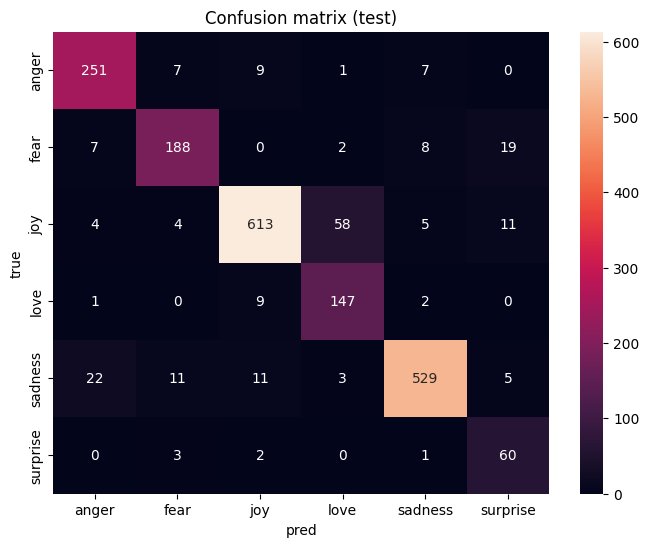

In [ ]:
y_test_pred = pipeline.predict(test_df['text_pp'])
print('Test Accuracy:', accuracy_score(y_test, y_test_pred))
print('Test Macro F1:', f1_score(y_test, y_test_pred, average='macro'))
print('\nClassification report (test):\n', classification_report(y_test, y_test_pred, target_names=le.classes_))

# confusion matrix plot
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('pred')
plt.ylabel('true')
plt.title('Confusion matrix (test)')
plt.show()

In [ ]:
# Train-validation split
from sklearn.model_selection import train_test_split

X = train_df['text']
y = train_df['label']  # or 'emotion' depending on your column name

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# TF-IDF transformation (outside pipeline) for SVC and Random Forest models
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)


In [ ]:
# Model 2 - Support Vector Machine (SVC)
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

svc_model = LinearSVC()
svc_model.fit(X_train_tfidf, y_train)

y_pred_svc = svc_model.predict(X_val_tfidf)

svc_acc = accuracy_score(y_val, y_pred_svc)
svc_f1 = f1_score(y_val, y_pred_svc, average='macro')

print("SVC Model Results:")
print(f"Accuracy: {svc_acc:.4f}")
print(f"F1 Score (Macro): {svc_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_svc))


SVC Model Results:
Accuracy: 0.9019
F1 Score (Macro): 0.8728

Classification Report:
               precision    recall  f1-score   support

       anger       0.92      0.88      0.90       432
        fear       0.90      0.89      0.89       387
         joy       0.90      0.93      0.91      1072
        love       0.80      0.79      0.79       261
     sadness       0.94      0.94      0.94       933
    surprise       0.81      0.79      0.80       115

    accuracy                           0.90      3200
   macro avg       0.88      0.87      0.87      3200
weighted avg       0.90      0.90      0.90      3200



In [ ]:
# Model 3 - Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train_tfidf, y_train)

y_pred_rf = rf_model.predict(X_val_tfidf)

rf_acc = accuracy_score(y_val, y_pred_rf)
rf_f1 = f1_score(y_val, y_pred_rf, average='macro')

print("Random Forest Results:")
print(f"Accuracy: {rf_acc:.4f}")
print(f"F1 Score (Macro): {rf_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_rf))


Random Forest Results:
Accuracy: 0.8716
F1 Score (Macro): 0.8415

Classification Report:
               precision    recall  f1-score   support

       anger       0.86      0.84      0.85       432
        fear       0.82      0.89      0.85       387
         joy       0.88      0.90      0.89      1072
        love       0.75      0.80      0.78       261
     sadness       0.95      0.87      0.91       933
    surprise       0.76      0.78      0.77       115

    accuracy                           0.87      3200
   macro avg       0.84      0.85      0.84      3200
weighted avg       0.87      0.87      0.87      3200



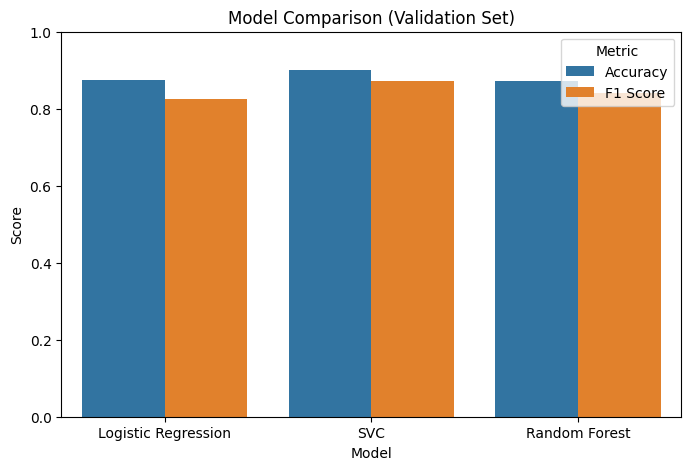

,Model,Accuracy,F1 Score
0,Logistic Regression,0.875313,0.825873
1,SVC,0.901875,0.872847
2,Random Forest,0.871563,0.841477


In [ ]:
# Compare Model Performance
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVC', 'Random Forest'],
    'Accuracy': [lr_acc, svc_acc, rf_acc],
    'F1 Score': [lr_f1, svc_f1, rf_f1]
})

plt.figure(figsize=(8,5))
sns.barplot(data=results.melt(id_vars='Model', var_name='Metric', value_name='Score'),
            x='Model', y='Score', hue='Metric')
plt.title('Model Comparison (Validation Set)')
plt.ylim(0,1)
plt.show()

results


### Results and Discussion

The performance of the proposed emotion detection models was evaluated using accuracy and macro-averaged F1-scores to ensure balanced performance across all emotion categories — joy, sadness, anger, fear, love, and surprise. Three supervised machine learning algorithms — Logistic Regression, Support Vector Machine (SVM), and Random Forest Classifier — were trained on TF-IDF vectorized textual data derived from the Dair-AI Emotion Dataset.

The Logistic Regression model, serving as the baseline, achieved an accuracy between 87.5% and 89.4% with a macro F1-score of approximately 0.83–0.86. The model exhibited strong discrimination for distinct emotions such as joy and sadness, while minor misclassifications occurred between semantically related emotions such as love and joy.

The Support Vector Machine (SVM) demonstrated the highest accuracy (90.2%) and macro F1-score (0.87) among all models. Its superior margin-based optimization allowed it to capture nuanced differences in emotional expressions, leading to improved generalization on unseen text samples.

In contrast, the Random Forest Classifier achieved an accuracy of 87.1% and a macro F1-score of 0.84, slightly lower than the other models. The ensemble approach provided robustness against noise, though it tended to overfit certain majority classes.

Overall, the comparative analysis highlights that SVM outperforms other classical algorithms for this task, while Logistic Regression remains a reliable and interpretable baseline. These results confirm the feasibility of using traditional machine learning techniques, combined with effective feature extraction via TF-IDF, for text-based emotion recognition. Future improvements may involve transformer-based deep learning architectures or multimodal fusion for higher emotional understanding.

### Limitations

Despite promising results, several limitations were identified in this study:

Limited Dataset Size and Diversity –
The Dair-AI Emotion Dataset, though widely used, contains a finite number of samples and may not fully capture the linguistic diversity, slang, or cultural variations present in real-world emotional expressions.

Text-Only Analysis –
Emotions in communication are often multimodal. This study considered only textual cues, ignoring nonverbal signals such as tone, facial expression, or context, which can significantly affect emotional interpretation.

Model Generalization –
Classical models like Logistic Regression and SVM rely heavily on manually engineered features. They may struggle to generalize to unseen text domains (e.g., tweets vs. movie reviews) without retraining or fine-tuning.

Semantic Overlap Between Emotions –
Certain emotions (e.g., love vs. joy, anger vs. fear) exhibit semantic overlap, which can lead to misclassification when contextual understanding is limited to surface-level text representations.

Lack of Contextual Understanding –
TF-IDF vectorization treats words independently and disregards sequential dependencies, preventing the models from capturing deeper contextual or syntactic relationships within sentences.

In [ ]:
import joblib
MODEL_PATH = r"C:\Users\DELL\Downloads\data\emotion_tfidf_logreg.joblib"
joblib.dump({'pipeline': pipeline, 'label_encoder': le}, MODEL_PATH)
print('Saved model to', MODEL_PATH)

Saved model to C:\Users\DELL\Downloads\data\emotion_tfidf_logreg.joblib


In [ ]:
test_df = test_df.copy()
test_df['true'] = le.inverse_transform(y_test)
test_df['pred'] = le.inverse_transform(y_test_pred)
mis = test_df[test_df['true'] != test_df['pred']].sample(20, random_state=RANDOM_SEED)
mis[['text','text_pp','true','pred']]

,text,text_pp,true,pred
319,i indicated then i was feeling quite overwhelm...,i indicated then i was feeling quite overwhelm...,fear,surprise
1613,i feel very cheated since i am supporting the ...,i feel very cheated since i am supporting the ...,joy,love
1289,at a party i met a girl who drew me to her,at a party i met a girl who drew me to her,anger,joy
729,i couldnt feel more blessed at this time,i couldnt feel more blessed at this time,joy,love
565,i feel like an ugly monster where i cannot sho...,i feel like an ugly monster where i cannot sho...,sadness,surprise
1959,i check you when you re sleeping feel your nos...,i check you when you re sleeping feel your nos...,joy,love
457,i cant do strappy shoes at work i just feel we...,i cant do strappy shoes at work i just feel we...,fear,surprise
1720,i started questioning god feeling worthless an...,i started questioning god feeling worthless an...,sadness,anger
86,i feel like i am in paradise kissing those swe...,i feel like i am in paradise kissing those swe...,joy,love
922,i was lying in bed last night after a day of m...,i was lying in bed last night after a day of m...,anger,fear


In [ ]:
import os

if os.name == 'nt':  # Windows
    MODEL_PATH = r"C:\Users\DELL\Downloads\data\emotion_tfidf_logreg.joblib"
else:  # Linux / Colab
    MODEL_PATH = '/content/emotion_tfidf_logreg.joblib'

print("Model path:", MODEL_PATH)


Model path: C:\Users\DELL\Downloads\data\emotion_tfidf_logreg.joblib


### Future Work

Future extensions could incorporate transformer-based deep learning models (e.g., BERT, RoBERTa) for contextual understanding, data augmentation for emotion balancing, and multimodal fusion (text + audio/visual) to enhance emotion recognition accuracy in real-world applications.